In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import random
import cv2
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display

from tqdm import tqdm

torch.manual_seed(0);
# Set random seed for reproducibility
random.seed(0)

### Network

In [2]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

class Generator(nn.Module):
    def __init__(self, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
       
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8,  kernel_size=3, stride=2, padding=1,output_padding=1),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4,  kernel_size=3, stride=2, padding=1,output_padding=1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=3, stride=2, padding=1,output_padding=1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf,  kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf, nc, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, input):
      
        return self.main(input)
       

class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(

            nn.Conv2d(nc, ndf, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf * 4,kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf*4, ndf * 4,kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, nc, kernel_size=3, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

#### Dades

In [3]:
import os
import pandas as pd
from torchvision.io import read_image

class MyMnist(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.img_dir = os.listdir(path)
        self.transform = transform 
        self.images = []
        self.labels = []
        
        for name in self.img_dir:
            img_path = os.path.join(self.path, name)
            image = read_image(img_path) / 255
            image = image.type(torch.FloatTensor)
            label = float(img_path.split("_")[1][0])
            if self.transform:
                image = self.transform(image)
                
            self.images.append(image)
            self.labels.append(int(label))
    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        
        return self.images[idx], self.labels[idx]

In [7]:
data_loader_train = torch.utils.data.DataLoader(MyMnist("C:/Users/Ivan/Downloads/Master/TFM/data/train/"), batch_size=64, shuffle=True)
data_loader_val = torch.utils.data.DataLoader(MyMnist("C:/Users/Ivan/Downloads/Master/TFM/data/test/"), batch_size=64, shuffle=False)  

### Entrenament

#### Paràmetres d'entrenament

In [8]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# latent space dimension
ld = 2
# number of generator filters
ngf = 32
#number of discriminator filters
ndf = 32
num_epochs = 10

In [17]:
netG = Generator(nz=ld).to(device)
netG.apply(weights_init)
#netG.load_state_dict(torch.load('my_nets/netG_epoch_99.pth'))

netD = Discriminator().to(device)
netD.apply(weights_init)
#netD.load_state_dict(torch.load('my_nets/netD_epoch_99.pth'))

criterion = nn.BCELoss()

# setup optimizer
batch_size = 64 #Hauría de ser consistent amb el batch size de les dades
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

pbar = tqdm(range(1, num_epochs+1)) # tdqm permet tenir text dinàmic # tdqm permet tenir text dinàmic

optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.999))

losses = np.zeros(num_epochs)
losses_val = np.zeros(num_epochs)

for epoch in pbar:
    for i, (data, _) in enumerate(data_loader_train, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad() 
        data = data.to(device)
        batch_size = data.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float,device=device)

        output = netD(data)
        
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        pbar.set_description('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                   % (epoch, num_epochs, i, len(data_loader_train),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        #if i % 100 == 0:
        #    vutils.save_image(real_cpu,'output/real_samples.png' ,normalize=True)
        #    fake = netG(fixed_noise)
        #    vutils.save_image(fake.detach(),'output/fake_samples_epoch_%03d.png' % (epoch), normalize=True)        
    
    #torch.save(netG.state_dict(), 'weights/netG_epoch_%d.pth' % (epoch))
    #torch.save(netD.state_dict(), 'weights/netD_epoch_%d.pth' % (epoch))

  0%|          | 0/10 [00:00<?, ?it/s]

[1/10][443/750] Loss_D: 0.0005 Loss_G: 8.0962 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003:   0%|          | 0/10 [00:05<?, ?it/s]


KeyboardInterrupt: 

### Generació de dades

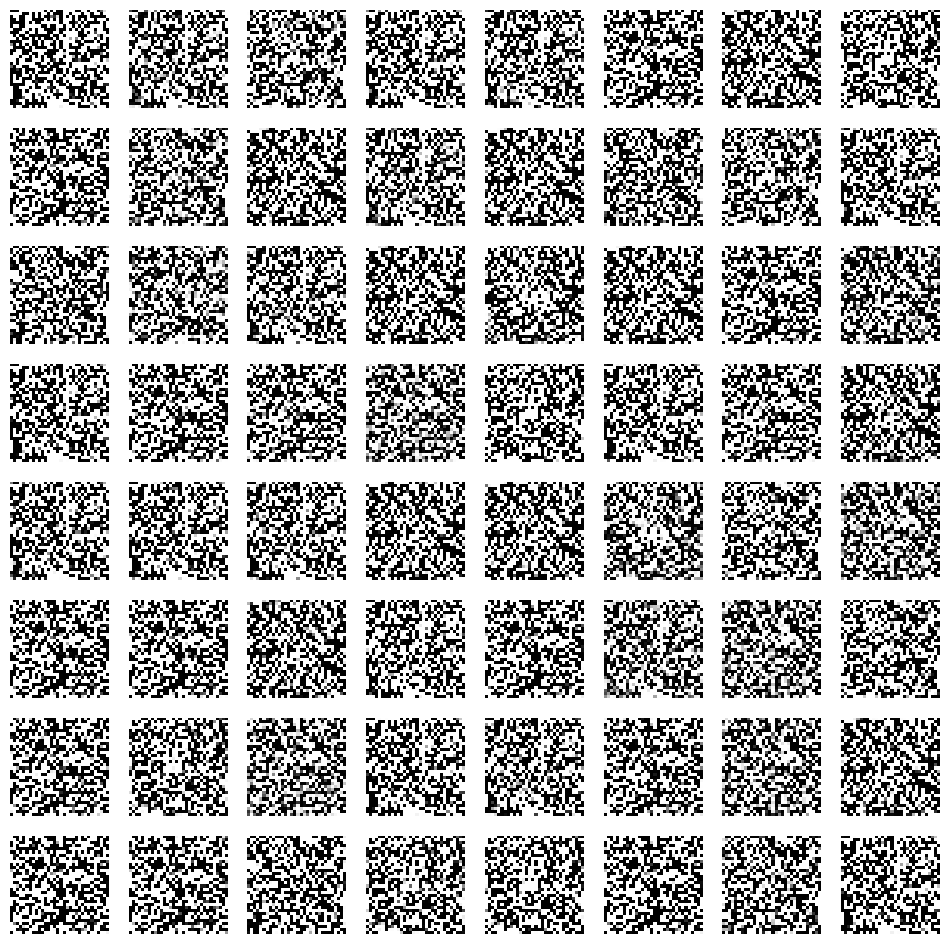

In [11]:
latent_size = ld
batch_size = 64
fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
    
fake_images = netG(fixed_noise)

fake_images_np = fake_images.cpu().detach().numpy()

fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 32, 32)
R, C = 8, 8

fig = plt.figure(figsize=(12, 12))

for i in range(batch_size):
  
    axes = fig.add_subplot(R, C, i+1)
    axes.imshow(fake_images_np[i], cmap='gray');
    axes.set_axis_off()

plt.show();

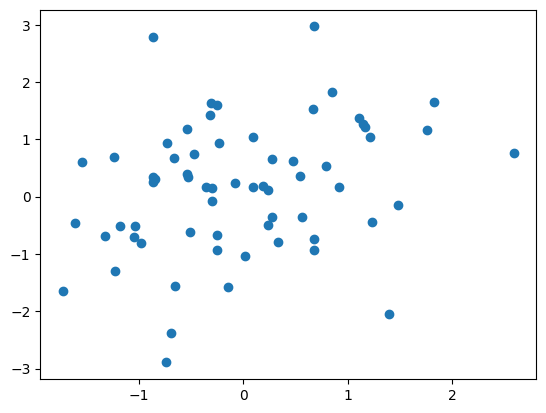

In [12]:
plt.scatter(fixed_noise[:,0,:,:].cpu(),fixed_noise[:,1,:,:].cpu());

### Projectam l'espai

In [13]:
myspace = [(x, y) for x in np.linspace(-3, 4, 20) for y in np.linspace(-3, 4,20)]
myspace = torch.tensor(myspace, dtype=torch.float32)
data_loader_myspace = torch.utils.data.DataLoader(list(zip(myspace, [11]*len(myspace))), batch_size=400, shuffle=False)

In [14]:
len(myspace)

400

In [15]:
x.shape

NameError: name 'x' is not defined

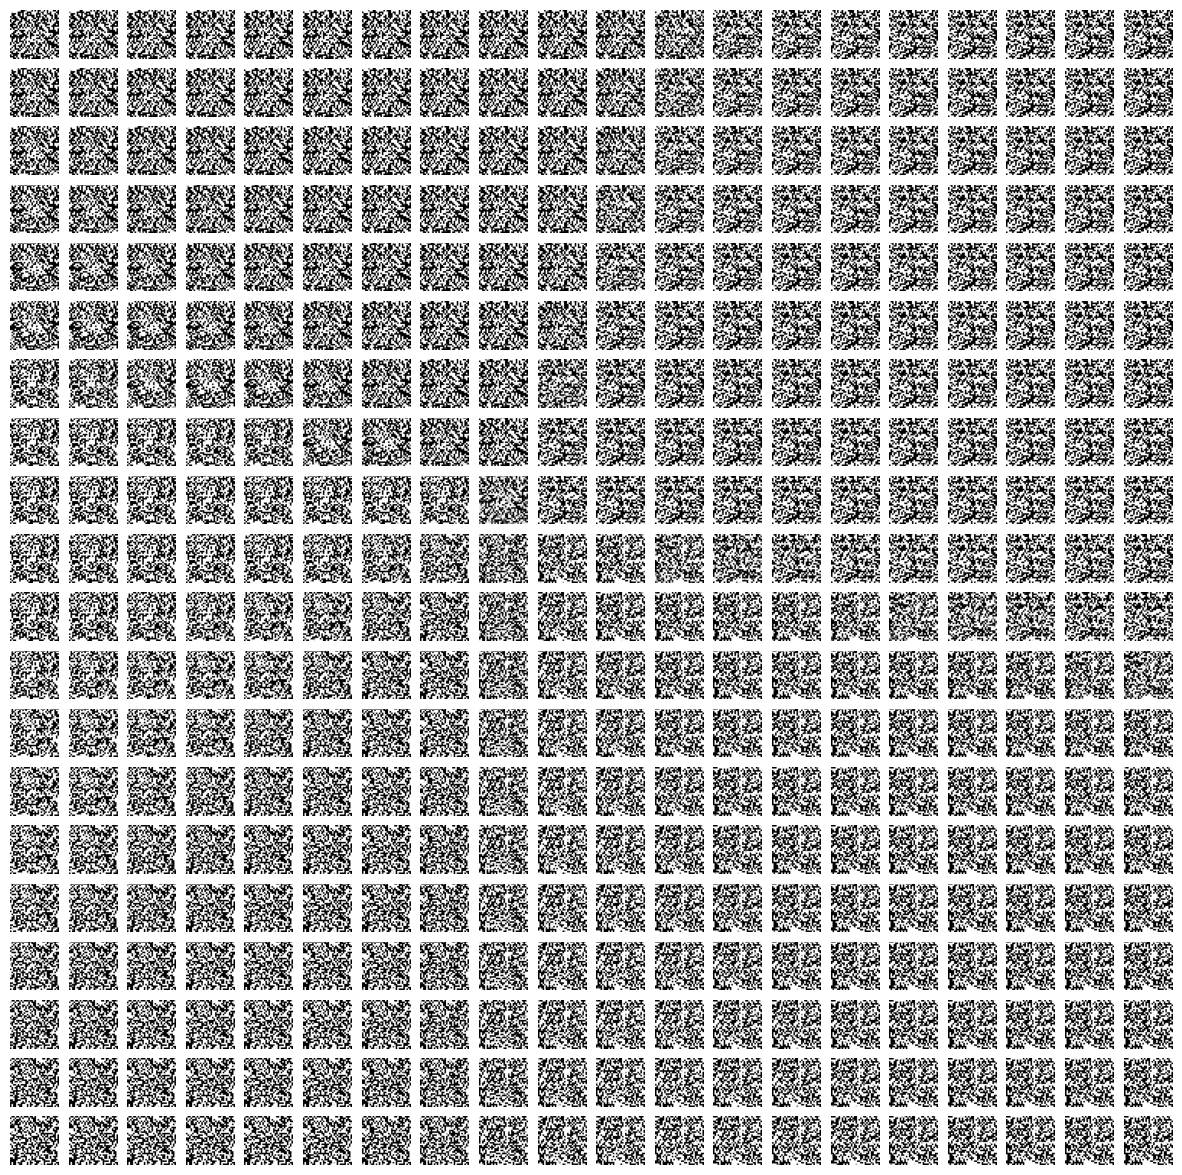

In [16]:
netG.eval()
fig = plt.figure(figsize=(15, 15))

for data in data_loader_myspace:
    # Forward pass
    x, label = data
    x = x.to(device)
    xx = torch.randn(400, nz, 1, 1, device=device)
    xx[:,:,0,0] = x 
    fake = netG(xx)
    for i in range(len(fake[:,0,:,:])):
        axes = fig.add_subplot(20,20, i+1)
        axes.imshow(fake[i,0,:,:].detach().cpu().numpy(), cmap='gray');
        axes.set_axis_off()

plt.show()